In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
# Attribute Information:

data_info = pd.read_csv("dataset/NUSW-NB15_features.csv", encoding = "ISO-8859-1")

In [3]:
# Retrieve Attribute Names

column_attributes = list (data_info['Name']) 

In [4]:
# Read the data available in 4 csv files using temporary data frames

dataframe1 = pd.read_csv("dataset/UNSW-NB15_1.csv",low_memory=False, header=None)
dataframe2 = pd.read_csv("dataset/UNSW-NB15_2.csv", low_memory=False, header=None)
dataframe3 = pd.read_csv("dataset/UNSW-NB15_3.csv", low_memory=False, header=None)
dataframe4 = pd.read_csv("dataset/UNSW-NB15_4.csv",low_memory=False, header=None)

In [5]:
# Name the columns of all data frames using attribute names from features.csv

df_list = [dataframe1,dataframe2,dataframe3,dataframe4]
for df in df_list:
    name = [v.lower() for k, v in enumerate(column_attributes)]
    df.columns = name

In [6]:
# Concatenate the 4 temporary data frames into one single data frame

dataset = pd.concat([dataframe1, dataframe2, dataframe3, dataframe4])
dataset.shape

(2540047, 49)

In [7]:
# Delete temporary data frames

del dataframe1
del dataframe2
del dataframe3
del dataframe4

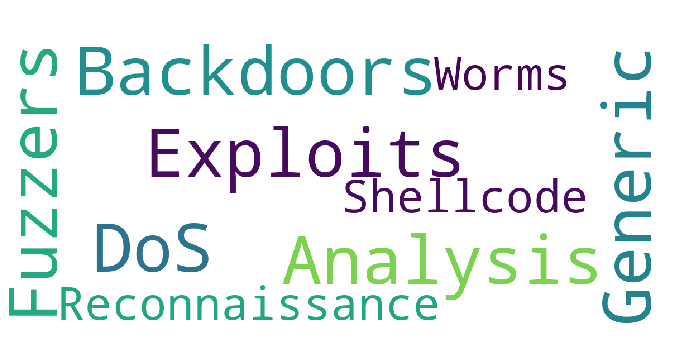

In [13]:
# Function to show the different attack cateegories present in the dataset

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):

    attack_catgs = data.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)
    attack_catgs = attack_catgs.dropna().to_numpy()
    attack_catgs = [x.strip(' ') for x in attack_catgs]
    attack_catgs = np.unique(attack_catgs)
    text = " ".join(str(item) for item in attack_catgs)
    wordcloud = WordCloud(
        background_color='white',
        collocations=False,
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
 
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(dataset)

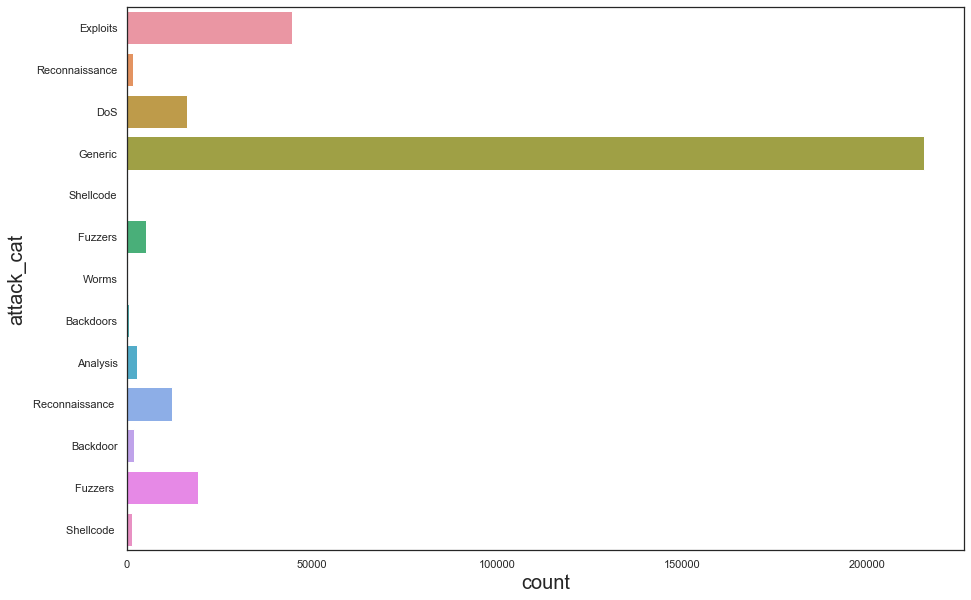

In [40]:
# Plot to show the distribution of all attack categories

def plot_attack_category(data):
    sns.set(rc={'figure.figsize':(15,10),"font.size":70,"axes.titlesize":40,"axes.labelsize":20},style="white")
    catg_plot = sns.countplot(y='attack_cat',data = data)
    
plot_attack_category(dataset)

In [79]:
# Do this later
'''
def plot_correlation(data):
    corr = data.corr()
    #print(corr)
    plt.figure(figsize=(19, 15))
    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,square=True,annot_kws={"size":12},cmap="YlGnBu")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right',fontsize = 30)
    
plot_correlation(dataset)
'''


'\ndef plot_correlation(data):\n    corr = data.corr()\n    #print(corr)\n    plt.figure(figsize=(19, 15))\n    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,square=True,annot_kws={"size":12},cmap="YlGnBu")\n    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment=\'right\',fontsize = 30)\n    \nplot_correlation(dataset)\n'

In [41]:
# Provided data is not consistent. Check and make relevant changes

columns_with_space = dataset.columns[dataset.isin([' ']).any()].tolist()
print('columns_with_space ',columns_with_space)
columns_with_null = dataset.columns[dataset.isna().any()].tolist()
print('columns_with_null ', columns_with_null)
columns_with_dash = dataset.columns[dataset.isin(['-']).any()].tolist()
print('columns_with_dash', columns_with_dash)

columns_with_space  ['ct_ftp_cmd']
columns_with_null  ['ct_flw_http_mthd', 'is_ftp_login', 'attack_cat']
columns_with_dash ['sport', 'dsport', 'service']


In [42]:
# Handle null and '-' values

# Where attack_cat not mentioned, replace with 'Normal'
dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace(np.nan,'Normal', regex=True)

dataset.loc[:,'ct_flw_http_mthd'] = dataset.loc[:,'ct_flw_http_mthd'].replace(np.nan,0, regex=True)
dataset.loc[:,'is_ftp_login'] = dataset.loc[:,'is_ftp_login'].replace(np.nan,0, regex=True)

dataset.loc[:,'ct_ftp_cmd'] = dataset.loc[:,'ct_ftp_cmd'].replace(' ',0, regex=True)

dataset.loc[:,'sport'] = dataset.loc[:,'sport'].replace('-',0, regex=False)
dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].replace('-',0, regex=False)
dataset.loc[:,'service'] = dataset.loc[:,'service'].replace('-','Others', regex=False)

dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)

In [43]:
# Columns that have String values

categorical_values = dataset.select_dtypes(exclude=['number']).keys()
print('categorical_values ', categorical_values)

categorical_values  Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object')


In [44]:
# ct_ftp_cmd field has erroneous String values, such as '0' instead of 0. Handle those values

arrg = dataset.loc[:, 'ct_ftp_cmd'].astype('str')
dataset.loc[:, 'ct_ftp_cmd'] = pd.to_numeric(arrg, errors='coerce').fillna(0).astype(np.int32)
print(dataset.loc[:, 'ct_ftp_cmd'].unique())
print('ct_ftp_cmd', dataset.loc[:, 'ct_ftp_cmd'].dtypes)

[0 1 6 2 4 8 5 3]
ct_ftp_cmd int32


In [45]:
# Label Encoding for categorical values. Can't do one hot encoding as it will result in huge increase in column size.

dataset.loc[:,'srcip'] = dataset.loc[:,'srcip'].astype('category')
# Assigning numerical values
dataset.loc[:,'srcip'] = dataset.loc[:,'srcip'].cat.codes

dataset.loc[:,'sport'] = dataset.loc[:,'sport'].astype('category')
# Assigning numerical values 
dataset.loc[:,'sport'] = dataset.loc[:,'sport'].cat.codes

dataset.loc[:,'dstip'] = dataset.loc[:,'dstip'].astype('category')
# Assigning numerical values
dataset.loc[:,'dstip'] = dataset.loc[:,'dstip'].cat.codes

dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].astype('category')
# Assigning numerical values
dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].cat.codes

In [46]:
# Print dataframe after label encoding

dataset[0:5]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,33,68854,24,47344,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,Normal,0
1,33,90600,27,253,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,Normal,0
2,39,69669,25,47344,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,Normal,0
3,38,93095,23,47344,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,Normal,0
4,36,108205,8,47344,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,Normal,0


In [47]:
# Store input columns in X

X = dataset.iloc[:,0:47]
print(X[0:5])

   srcip   sport  dstip  dsport proto state       dur  sbytes  dbytes  sttl  \
0     33   68854     24   47344   udp   CON  0.001055     132     164    31   
1     33   90600     27     253   udp   CON  0.036133     528     304    31   
2     39   69669     25   47344   udp   CON  0.001119     146     178    31   
3     38   93095     23   47344   udp   CON  0.001209     132     164    31   
4     36  108205      8   47344   udp   CON  0.001169     146     178    31   

   ...  ct_flw_http_mthd  is_ftp_login  ct_ftp_cmd ct_srv_src  ct_srv_dst  \
0  ...               0.0           0.0           0          3           7   
1  ...               0.0           0.0           0          2           4   
2  ...               0.0           0.0           0         12           8   
3  ...               0.0           0.0           0          6           9   
4  ...               0.0           0.0           0          7           9   

   ct_dst_ltm  ct_src_ ltm  ct_src_dport_ltm  ct_dst_sport_ltm

In [48]:
# Store output columns in Y

Y = dataset.iloc[:,-2:]
print(Y[0:5])

  attack_cat  label
0     Normal      0
1     Normal      0
2     Normal      0
3     Normal      0
4     Normal      0


In [49]:
# One Hot Encoding of those columns that have lesser unique values:

print('Unique categories count: proto ', len(X.loc[:,'proto'].unique()))
print('Unique categories count: state  ',len(X.loc[:,'state'].unique()))
print('Unique categories count: service ', len(X.loc[:,'service'].unique()))
dummy_cols = ['proto', 'state', 'service']
X = pd.get_dummies(X, columns=dummy_cols)
print('Data After one hot encoding\n', X[0:5])

Unique categories count: proto  135
Unique categories count: state   16
Unique categories count: service  13
Data After one hot encoding
    srcip   sport  dstip  dsport       dur  sbytes  dbytes  sttl  dttl  sloss  \
0     33   68854     24   47344  0.001055     132     164    31    29      0   
1     33   90600     27     253  0.036133     528     304    31    29      0   
2     39   69669     25   47344  0.001119     146     178    31    29      0   
3     38   93095     23   47344  0.001209     132     164    31    29      0   
4     36  108205      8   47344  0.001169     146     178    31    29      0   

   ...  service_ftp  service_ftp-data  service_http  service_irc  \
0  ...            0                 0             0            0   
1  ...            0                 0             0            0   
2  ...            0                 0             0            0   
3  ...            0                 0             0            0   
4  ...            0                 0    

In [50]:
# One Hot Encoding of output column 'attack_cat'

Y.loc[:,'attack_cat'] = [i.strip(' ') for i in Y.loc[:,'attack_cat']]
print('attack cat ', (Y.loc[:,'attack_cat'].unique()))
Y_enc = pd.get_dummies(Y, columns=['attack_cat'])

attack cat  ['Normal' 'Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode'
 'Fuzzers' 'Worms' 'Backdoors' 'Analysis']


In [51]:
print(Y_enc[0:5])

   label  attack_cat_Analysis  attack_cat_Backdoors  attack_cat_DoS  \
0      0                    0                     0               0   
1      0                    0                     0               0   
2      0                    0                     0               0   
3      0                    0                     0               0   
4      0                    0                     0               0   

   attack_cat_Exploits  attack_cat_Fuzzers  attack_cat_Generic  \
0                    0                   0                   0   
1                    0                   0                   0   
2                    0                   0                   0   
3                    0                   0                   0   
4                    0                   0                   0   

   attack_cat_Normal  attack_cat_Reconnaissance  attack_cat_Shellcode  \
0                  1                          0                     0   
1                  1          

In [52]:
# Normalization

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
# Pass parameter type = 'statistical' or 'minmax'
# Note: statistical is better for SVM and KNN.
def normalization(data, type='minmax'):
    if type == 'statistical':
        return stats.zscore(data)
    elif type == 'minmax':
        scaler = MinMaxScaler()
        return scaler.fit_transform(data)
    else:
        print('\n Norm type not found! \n')

In [53]:
X = normalization(X, 'minmax')
print(X[0:5])

[[0.78571429 0.53324763 0.52173913 ... 0.         0.         0.        ]
 [0.78571429 0.70166199 0.58695652 ... 0.         0.         0.        ]
 [0.92857143 0.53955949 0.54347826 ... 0.         0.         0.        ]
 [0.9047619  0.72098481 0.5        ... 0.         0.         0.        ]
 [0.85714286 0.83800592 0.17391304 ... 0.         0.         0.        ]]
